In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. rpy2 및 R 환경 설정 ---
# [사용자 설정] R 콘솔에서 R.home() 을 실행하여 나온 실제 경로로 수정해주세요.
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.5.1'

# 1-2. R의 bin 폴더 경로를 시스템 PATH 환경 변수에 추가 (Windows DLL 로드 오류 방지)
r_home = os.environ.get('R_HOME')
r_bin_path = os.path.join(r_home, 'bin', 'x64')
current_path = os.environ.get('PATH', '')
if r_bin_path not in current_path:
    os.environ['PATH'] = r_bin_path + ';' + current_path

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter

# R 라이브러리 import: acepack과 dcor 계산을 위한 energy
acepack = importr('acepack')
energy = importr('energy')
# ---

# --- 2. 시뮬레이션 조건 정의 ---
conditions = [
    {'id': 'Cond01', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond02', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond03', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond04', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond05', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond06', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond07', 'f_str': 'y = -x^3', 'func': lambda x: -(x**3),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond08', 'f_str': 'y = x^4', 'func': lambda x: x**4,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond09', 'f_str': 'y = x^5', 'func': lambda x: x**5,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond10', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond11', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'uniform', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond12', 'f_str': 'y = ln(|x|+1)', 'func': lambda x: np.log(np.abs(x) + 1),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond13', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond14', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond15', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond16', 'f_str': 'y = x^2 + U(0, 0.1)', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'uniform', 'err_params': (0, 1/10)},
]

# --- 3. 일반 설정 ---
np.random.seed(42)
n_samples = 2000
output_dir = "ace_simulations_fully_calculated"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- 4. NumPy <-> R 변환 컨텍스트 안에서 전체 루프 실행 ---
with localconverter(ro.default_converter + numpy2ri.converter):
    for cond in conditions:
        # --- 데이터 생성 ---
        if cond['x_dist'] == 'normal':
            x_samples = np.random.normal(loc=cond['x_params'][0], scale=cond['x_params'][1], size=n_samples)
        else:
            x_samples = np.random.uniform(low=cond['x_params'][0], high=cond['x_params'][1], size=n_samples)

        if cond['err_dist'] == 'normal':
            error_samples = np.random.normal(loc=cond['err_params'][0], scale=cond['err_params'][1], size=n_samples)
        else:
            error_samples = np.random.uniform(low=cond['err_params'][0], high=cond['err_params'][1], size=n_samples)
            
        y_samples = cond['func'](x_samples) + error_samples

        # R 함수에 맞게 numpy 배열을 R 벡터로 변환
        r_x = ro.FloatVector(x_samples)
        r_y = ro.FloatVector(y_samples)
        
        # --- ACE 변환 및 상관계수 계산 ---
        ace_results_r = acepack.ace(r_x, r_y)
        
        # [수정됨] .names를 함수로 호출 -> names()
        r_names_list = list(ace_results_r.names())
        tx_index = r_names_list.index('tx')
        ty_index = r_names_list.index('ty')
        transformed_x = np.array(ace_results_r[tx_index])
        transformed_y = np.array(ace_results_r[ty_index])
        
        # dcor를 R의 energy::dcor 함수로 실제 계산
        abs_pearson_corr_before = round(abs(np.corrcoef(x_samples, y_samples)[0, 1]), 2)
        dcor_before_r = energy.dcor(r_x, r_y)
        abs_dist_corr_before = round(dcor_before_r[0], 2)
        
        r_tx = ro.FloatVector(transformed_x.flatten())
        r_ty = ro.FloatVector(transformed_y.flatten())
        
        abs_pearson_corr_after = round(abs(np.corrcoef(transformed_x.flatten(), transformed_y.flatten())[0, 1]), 2)
        dcor_after_r = energy.dcor(r_tx, r_ty)
        abs_dist_corr_after = round(dcor_after_r[0], 2)

        # --- 그래프 생성 ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        title = f"{cond['id']}: {cond['f_str']} | X~{cond['x_dist'].capitalize()}{cond['x_params']}, ε~{cond['err_dist'].capitalize()}{cond['err_params']}"
        fig.suptitle(title, fontsize=12)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)

        ax1.scatter(x_samples, y_samples, alpha=0.3, s=5)
        ax1.set_title('Before Transformation')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        text_before = (f"|Pearson Corr|: {abs_pearson_corr_before:.2f}\n"
                       f"|Distance Corr|: {abs_dist_corr_before:.2f}")
        ax1.text(0.05, 0.95, text_before, transform=ax1.transAxes, fontsize=11, verticalalignment='top', bbox=props)

        ax2.scatter(transformed_x.flatten(), transformed_y.flatten(), alpha=0.3, s=5, color='green')
        ax2.set_title('After ACE Transformation (Calculated)')
        ax2.set_xlabel('Transformed X: $θ(X)$')
        ax2.set_ylabel('Transformed Y: $φ(Y)$')
        text_after = (f"|Pearson Corr|: {abs_pearson_corr_after:.2f}\n"
                      f"|Distance Corr|: {abs_dist_corr_after:.2f}")
        ax2.text(0.05, 0.95, text_after, transform=ax2.transAxes, fontsize=11, verticalalignment='top', bbox=props)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        filename = f"{output_dir}/{cond['id']}.png"
        plt.savefig(filename)
        plt.close(fig)

print(f"모든 시뮬레이션이 완료되었습니다. 총 {len(conditions)}개의 그래프가 '{output_dir}' 폴더에 저장되었습니다.")

모든 시뮬레이션이 완료되었습니다. 총 16개의 그래프가 'ace_simulations_fully_calculated' 폴더에 저장되었습니다.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- 1. rpy2 및 R 환경 설정 ---
# [사용자 설정] R 콘솔에서 R.home() 을 실행하여 나온 실제 경로로 수정해주세요.
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.5.1'

# 1-2. R의 bin 폴더 경로를 시스템 PATH 환경 변수에 추가 (Windows DLL 로드 오류 방지)
r_home = os.environ.get('R_HOME')
r_bin_path = os.path.join(r_home, 'bin', 'x64')
current_path = os.environ.get('PATH', '')
if r_bin_path not in current_path:
    os.environ['PATH'] = r_bin_path + ';' + current_path

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter

# R 라이브러리 import: acepack과 dcor 계산을 위한 energy
acepack = importr('acepack')
energy = importr('energy')
# ---

# --- 2. 시뮬레이션 조건 정의 ---
conditions = [
    {'id': 'Cond01', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond02', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond03', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond04', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond05', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond06', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond07', 'f_str': 'y = -x^3', 'func': lambda x: -(x**3),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond08', 'f_str': 'y = x^4', 'func': lambda x: x**4,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond09', 'f_str': 'y = x^5', 'func': lambda x: x**5,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond10', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond11', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'uniform', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond12', 'f_str': 'y = ln(|x|+1)', 'func': lambda x: np.log(np.abs(x) + 1),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond13', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond14', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond15', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond16', 'f_str': 'y = x^2 + U(0, 0.1)', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'uniform', 'err_params': (0, 1/10)},
]

# --- 3. 일반 설정 및 결과 저장을 위한 초기화 ---
np.random.seed(42)
n_samples = 2000
output_dir = "ace_simulations_fully_calculated"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results_list = []

# 16개 조건을 4개씩 나누어 이미지 생성
fig = None
axes = None

# --- 4. NumPy <-> R 변환 컨텍스트 안에서 전체 루프 실행 ---
with localconverter(ro.default_converter + numpy2ri.converter):
    for i, cond in enumerate(conditions):
        # 4개의 조건마다 새로운 그림(figure)을 생성
        if i % 4 == 0:
            fig, axes = plt.subplots(4, 2, figsize=(10, 12))
            fig.suptitle(f'ACE Transformation Results', fontsize=16)

        # --- 데이터 생성 ---
        if cond['x_dist'] == 'normal':
            x_samples = np.random.normal(loc=cond['x_params'][0], scale=cond['x_params'][1], size=n_samples)
        else:
            x_samples = np.random.uniform(low=cond['x_params'][0], high=cond['x_params'][1], size=n_samples)

        if cond['err_dist'] == 'normal':
            error_samples = np.random.normal(loc=cond['err_params'][0], scale=cond['err_params'][1], size=n_samples)
        else:
            error_samples = np.random.uniform(low=cond['err_params'][0], high=cond['err_params'][1], size=n_samples)
            
        y_samples = cond['func'](x_samples) + error_samples

        r_x = ro.FloatVector(x_samples)
        r_y = ro.FloatVector(y_samples)
        
        # --- ACE 변환 및 상관계수 계산 ---
        ace_results_r = acepack.ace(r_x, r_y)
        
        # [수정됨] .names를 함수로 호출 -> names()
        r_names_list = list(ace_results_r.names())
        tx_index = r_names_list.index('tx')
        ty_index = r_names_list.index('ty')
        transformed_x = np.array(ace_results_r[tx_index])
        transformed_y = np.array(ace_results_r[ty_index])
        
        # dcor를 R의 energy::dcor 함수로 실제 계산
        abs_pearson_corr_before = round(abs(np.corrcoef(x_samples, y_samples)[0, 1]), 2)
        dcor_before_r = energy.dcor(r_x, r_y)
        abs_dist_corr_before = round(dcor_before_r[0], 2)
        
        r_tx = ro.FloatVector(transformed_x.flatten())
        r_ty = ro.FloatVector(transformed_y.flatten())
        
        abs_pearson_corr_after = round(abs(np.corrcoef(transformed_x.flatten(), transformed_y.flatten())[0, 1]), 2)
        dcor_after_r = energy.dcor(r_tx, r_ty)
        abs_dist_corr_after = round(dcor_after_r[0], 2)
        
        # 결과 딕셔너리를 만들어 리스트에 추가
        result_row = {
            'ID': cond['id'],
            'Function': cond['f_str'],
            'X Dist.': f"{cond['x_dist'].capitalize()}{cond['x_params']}",
            'Err Dist.': f"{cond['err_dist'].capitalize()}{cond['err_params']}",
            'Corr Before': abs_pearson_corr_before,
            'dCor Before': abs_dist_corr_before,
            'Corr After': abs_pearson_corr_after,
            'dCor After': abs_dist_corr_after
        }
        results_list.append(result_row)

        # --- 그리드에 그래프 생성 ---
        row_idx = i % 4
        ax_before = axes[row_idx, 0]
        ax_after = axes[row_idx, 1]

        # Before 그래프
        ax_before.scatter(x_samples, y_samples, alpha=0.3, s=5)
        text_before = (f"Pearson Corr:{abs_pearson_corr_before:.2f}, Dcor:{abs_dist_corr_before:.2f}")
        ax_before.set_title(f"{cond['id']}: {cond['f_str']}", fontsize=10)
        ax_before.set_ylabel("Before", fontsize=10)
        ax_before.text(0.05, 0.95, text_before, transform=ax_before.transAxes, fontsize=8, verticalalignment='top')
        
        # After 그래프
        ax_after.scatter(transformed_x.flatten(), transformed_y.flatten(), alpha=0.3, s=5, color='green')
        ax_after.set_title(f"After ACE", fontsize=10)
        text_after = (f"Pearson Corr:{abs_pearson_corr_after:.2f}, Dcor:{abs_dist_corr_after:.2f}")
        ax_after.text(0.05, 0.95, text_after, transform=ax_after.transAxes, fontsize=8, verticalalignment='top')
        
        # 4개의 조건이 끝나거나 전체 루프가 끝나면 그림을 저장
        if (i + 1) % 4 == 0 or (i + 1) == len(conditions):
            part_num = (i // 4) + 1
            fig.tight_layout(rect=[0, 0, 1, 0.96])
            plt.savefig(f"{output_dir}/simulations_part_{part_num}.png", dpi=150)
            plt.close(fig)

# --- 5. 최종 결과 출력 ---
# 데이터프레임 생성 및 출력
results_df = pd.DataFrame(results_list)

print("="*80)
print("Simulation Results Summary")
print("="*80)
display(results_df)

Simulation Results Summary


,ID,Function,X Dist.,Err Dist.,Corr Before,dCor Before,Corr After,dCor After
0,Cond01,y = x^2,"Normal(0, 1)","Normal(0, 1)",0.06,0.39,0.90,0.82
1,Cond02,y = x^2,"Uniform(-1, 1)","Normal(0, 1)",0.02,0.14,0.29,0.27
2,Cond03,y = -x^2,"Uniform(-1, 1)","Normal(0, 1)",0.02,0.14,0.30,0.28
3,Cond04,y = -x^2,"Normal(0, 1)","Uniform(0, 1)",0.02,0.52,0.99,0.98
4,Cond05,y = x^3,"Normal(0, 1)","Normal(0, 1)",0.71,0.74,0.96,0.93
5,Cond06,y = x^3,"Uniform(-1, 1)","Normal(0, 1)",0.32,0.28,0.33,0.29
6,Cond07,y = -x^3,"Uniform(-1, 1)","Normal(0, 1)",0.34,0.30,0.36,0.31
7,Cond08,y = x^4,"Normal(0, 1)","Normal(0, 1)",0.04,0.43,0.99,0.99
8,Cond09,y = x^5,"Normal(0, 1)","Normal(0, 1)",0.53,0.64,0.97,0.99
9,Cond10,y = e^x,"Normal(0, 1)","Normal(0, 1)",0.71,0.71,0.96,0.92


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
from sklearn.preprocessing import RobustScaler

# --- 1. rpy2 및 R 환경 설정 ---
# [사용자 설정] R 콘솔에서 R.home() 을 실행하여 나온 실제 경로로 수정해주세요.
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.5.1'

# 1-2. R의 bin 폴더 경로를 시스템 PATH 환경 변수에 추가 (Windows DLL 로드 오류 방지)
r_home = os.environ.get('R_HOME')
r_bin_path = os.path.join(r_home, 'bin', 'x64')
current_path = os.environ.get('PATH', '')
if r_bin_path not in current_path:
    os.environ['PATH'] = r_bin_path + ';' + current_path

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter

# R 라이브러리 import: acepack과 dcor 계산을 위한 energy
acepack = importr('acepack')
energy = importr('energy')
# ---

# --- 2. 시뮬레이션 조건 정의 ---
conditions = [
    {'id': 'Cond01', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond02', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond03', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond04', 'f_str': 'y = -x^2', 'func': lambda x: -(x**2),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond05', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond06', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond07', 'f_str': 'y = -x^3', 'func': lambda x: -(x**3),
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond08', 'f_str': 'y = x^4', 'func': lambda x: x**4,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond09', 'f_str': 'y = x^5', 'func': lambda x: x**5,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond10', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond11', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'uniform', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond12', 'f_str': 'y = ln(|x|+1)', 'func': lambda x: np.log(np.abs(x) + 1),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'normal', 'err_params': (0, 1)},
    {'id': 'Cond13', 'f_str': 'y = x^2', 'func': lambda x: x**2,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond14', 'f_str': 'y = x^3', 'func': lambda x: x**3,
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (-1, 1)},
    {'id': 'Cond15', 'f_str': 'y = e^x', 'func': lambda x: np.exp(x),
     'x_dist': 'normal', 'x_params': (0, 1), 'err_dist': 'uniform', 'err_params': (0, 1)},
    {'id': 'Cond16', 'f_str': 'y = x^2 + U(0, 0.1)', 'func': lambda x: x**2,
     'x_dist': 'uniform', 'x_params': (-1, 1), 'err_dist': 'uniform', 'err_params': (0, 1/10)},
]

# --- 3. 일반 설정 및 결과 저장을 위한 초기화 ---
np.random.seed(42)
n_samples = 2000
results_list = []

# --- 4. NumPy <-> R 변환 컨텍스트 안에서 전체 루프 실행 ---
with localconverter(ro.default_converter + numpy2ri.converter):
    for cond in conditions:
        print(f"Processing {cond['id']}...")
        # --- 데이터 생성 ---
        if cond['x_dist'] == 'normal':
            x_samples = np.random.normal(loc=cond['x_params'][0], scale=cond['x_params'][1], size=n_samples)
        else:
            x_samples = np.random.uniform(low=cond['x_params'][0], high=cond['x_params'][1], size=n_samples)

        if cond['err_dist'] == 'normal':
            error_samples = np.random.normal(loc=cond['err_params'][0], scale=cond['err_params'][1], size=n_samples)
        else:
            error_samples = np.random.uniform(low=cond['err_params'][0], high=cond['err_params'][1], size=n_samples)
            
        y_samples = cond['func'](x_samples) + error_samples

        r_x = ro.FloatVector(x_samples)
        r_y = ro.FloatVector(y_samples)
        
        # --- 1. 변환 전 dCor 계산 ---
        dcor_before = round(energy.dcor(r_x, r_y)[0], 4)

        # --- 2. 모든 변환 기법 적용 및 dCor 계산 ---
        
        # ACE
        ace_results_r = acepack.ace(r_x, r_y)
        
        # [수정됨] .names를 함수로 호출 -> names()
        r_names_list = list(ace_results_r.names())
        transformed_x_ace = np.array(ace_results_r[r_names_list.index('tx')])
        transformed_y_ace = np.array(ace_results_r[r_names_list.index('ty')])
        dcor_ace = round(energy.dcor(ro.FloatVector(transformed_x_ace.flatten()), ro.FloatVector(transformed_y_ace.flatten()))[0], 4)

        # 데이터가 음수일 경우를 대비해 작은 값을 더해 양수로 만듦
        y_positive = y_samples - y_samples.min() + 1e-6

        # Box-Cox
        y_boxcox, _ = stats.boxcox(y_positive)
        dcor_boxcox = round(energy.dcor(r_x, ro.FloatVector(y_boxcox.flatten()))[0], 4)
        
        # Yeo-Johnson
        y_yeojohnson, _ = stats.yeojohnson(y_samples)
        dcor_yeojohnson = round(energy.dcor(r_x, ro.FloatVector(y_yeojohnson.flatten()))[0], 4)

        # Robust Scaler
        scaler = RobustScaler()
        y_robust = scaler.fit_transform(y_samples.reshape(-1, 1))
        dcor_robust = round(energy.dcor(r_x, ro.FloatVector(y_robust.flatten()))[0], 4)

        # Log
        y_log = np.log(y_positive)
        dcor_log = round(energy.dcor(r_x, ro.FloatVector(y_log.flatten()))[0], 4)

        # --- 3. 결과 저장 ---
        improvements = {
            'ACE': dcor_ace - dcor_before,
            'Box-Cox': dcor_boxcox - dcor_before,
            'Yeo-Johnson': dcor_yeojohnson - dcor_before,
            'Robust Scaler': dcor_robust - dcor_before,
            'Log': dcor_log - dcor_before
        }
        
        best_method = max(improvements, key=improvements.get)

        result_row = {
            'ID': cond['id'],
            'Function': cond['f_str'],
            'dCor Before': dcor_before,
            'dCor ACE': dcor_ace,
            'dCor Box-Cox': dcor_boxcox,
            'dCor Yeo-Johnson': dcor_yeojohnson,
            'dCor Robust': dcor_robust,
            'dCor Log': dcor_log,
            'Best Method': best_method,
            'Improvement': improvements[best_method]
        }
        results_list.append(result_row)

# --- 5. 최종 결과 출력 ---
results_df = pd.DataFrame(results_list)

print("="*100)
print("Transformation Method Comparison Results")
print("="*100)
# display()는 Jupyter 환경에서만 작동하므로, print()로 대체하여 모든 환경에서 호환되도록 합니다.
print(results_df.round(4).to_string())

Processing Cond01...
Processing Cond02...
Processing Cond03...
Processing Cond04...
Processing Cond05...
Processing Cond06...
Processing Cond07...
Processing Cond08...
Processing Cond09...
Processing Cond10...
Processing Cond11...
Processing Cond12...
Processing Cond13...
Processing Cond14...
Processing Cond15...
Processing Cond16...
Transformation Method Comparison Results
        ID             Function  dCor Before  dCor ACE  dCor Box-Cox  dCor Yeo-Johnson  dCor Robust  dCor Log Best Method  Improvement
0   Cond01              y = x^2       0.3929    0.8204        0.3788            0.3734       0.3929    0.3647         ACE       0.4275
1   Cond02              y = x^2       0.1352    0.2719        0.1348            0.1349       0.1352    0.1304         ACE       0.1367
2   Cond03             y = -x^2       0.1404    0.2773        0.1404            0.1404       0.1404    0.1400         ACE       0.1369
3   Cond04             y = -x^2       0.5164    0.9775        0.5164            0.4

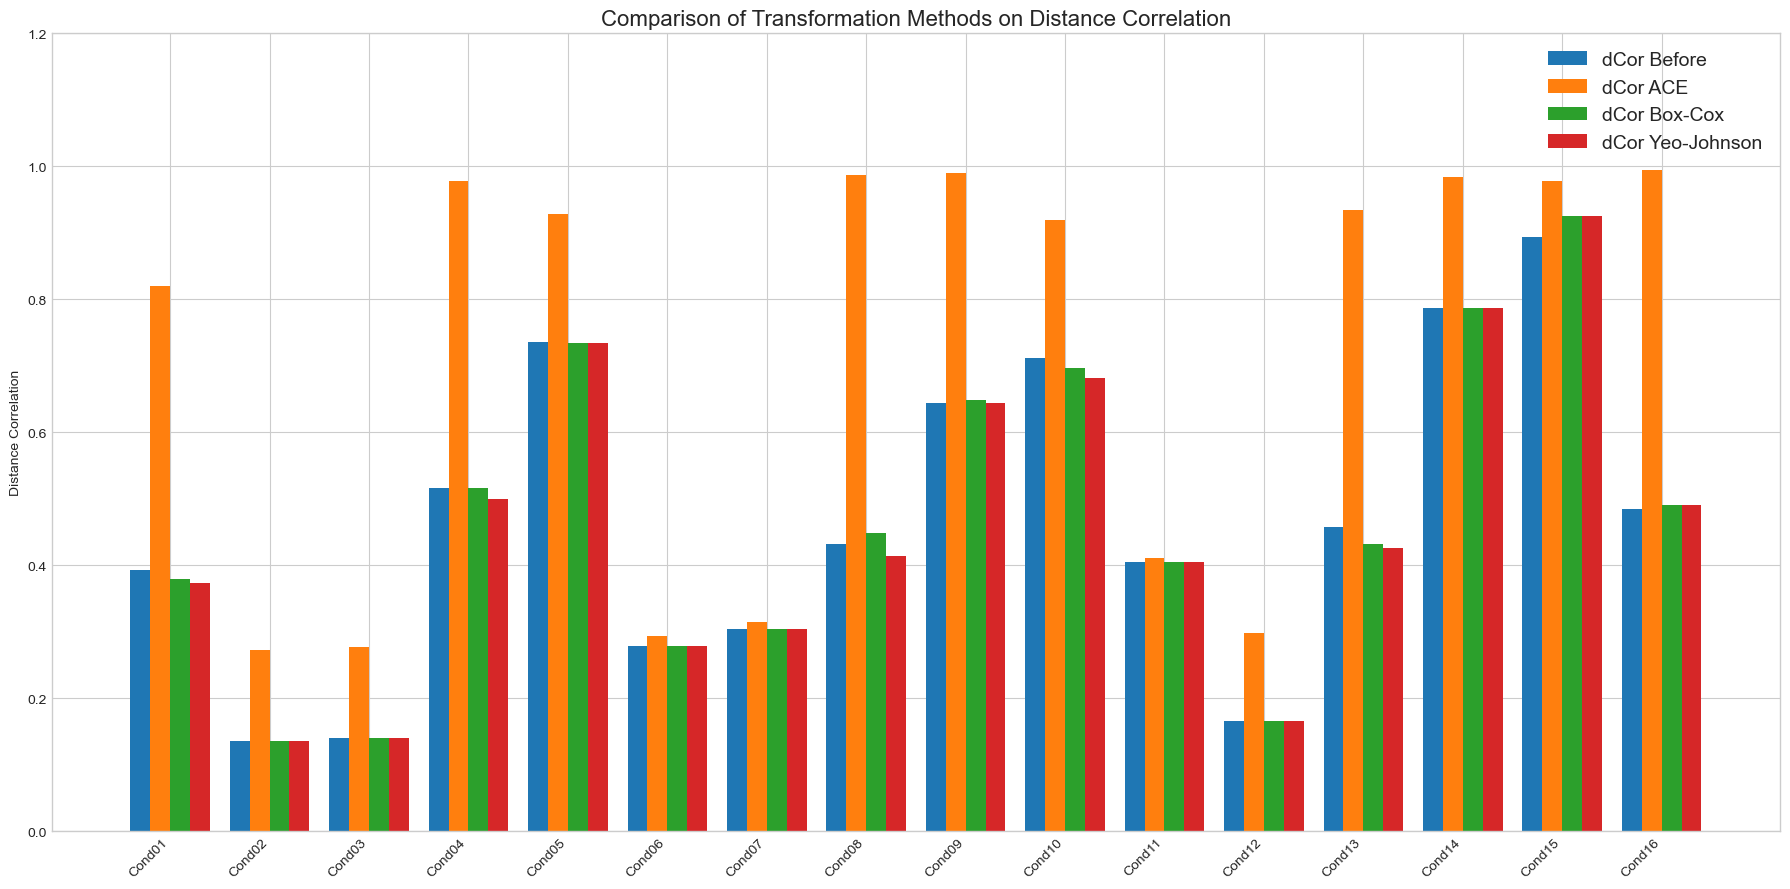

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 이 코드는 16개 조건에 대한 시뮬레이션이 모두 끝나고,
# 'results_df' 데이터프레임이 생성된 후에 실행해야 합니다.

# --- 전체 변환 기법 비교 막대그래프 코드 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 9))

# 비교할 변환 기법 목록 (사용자님의 DataFrame에 있는 실제 열 이름 사용)
# 만약 다른 기법도 비교하고 싶다면 이 리스트에 추가하세요.
methods = ['dCor Before', 'dCor ACE', 'dCor Box-Cox', 'dCor Yeo-Johnson']
num_methods = len(methods)
indices = np.arange(len(results_df))
width = 0.8 / num_methods # 전체 폭을 0.8로 잡고 메서드 수만큼 나눔

# 각 메서드에 대해 막대그래프 그리기
for i, method in enumerate(methods):
    # 막대 위치 계산
    offset = width * (i - (num_methods - 1) / 2)
    # results_df에 해당 열이 있을 경우에만 그래프를 그립니다.
    if method in results_df.columns:
        ax.bar(indices + offset, results_df[method], width, label=method)

ax.set_title('Comparison of Transformation Methods on Distance Correlation', fontsize=16)
ax.set_ylabel('Distance Correlation')
ax.set_xticks(indices)
ax.set_xticklabels(results_df['ID'], rotation=45, ha="right")
ax.legend(fontsize=14)
ax.set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

ACE Transformation Improvement Results (sorted by dCor Rank)


,ID,Function,dCor Before,dCor After,dCor Improvement,dCor Rank
7,Cond8,y = x^4,0.43,0.99,0.56,1
15,Cond16,"y = x^2 + U(0, 0.1)",0.48,0.99,0.51,2
12,Cond13,y = x^2,0.46,0.93,0.47,3
3,Cond4,y = -x^2,0.52,0.98,0.46,4
0,Cond1,y = x^2,0.39,0.82,0.43,5
8,Cond9,y = x^5,0.64,0.99,0.35,6
9,Cond10,y = e^x,0.71,0.92,0.21,7
4,Cond5,y = x^3,0.74,0.93,0.19,8
13,Cond14,y = x^3,0.79,0.98,0.19,9
2,Cond3,y = -x^2,0.14,0.28,0.14,10


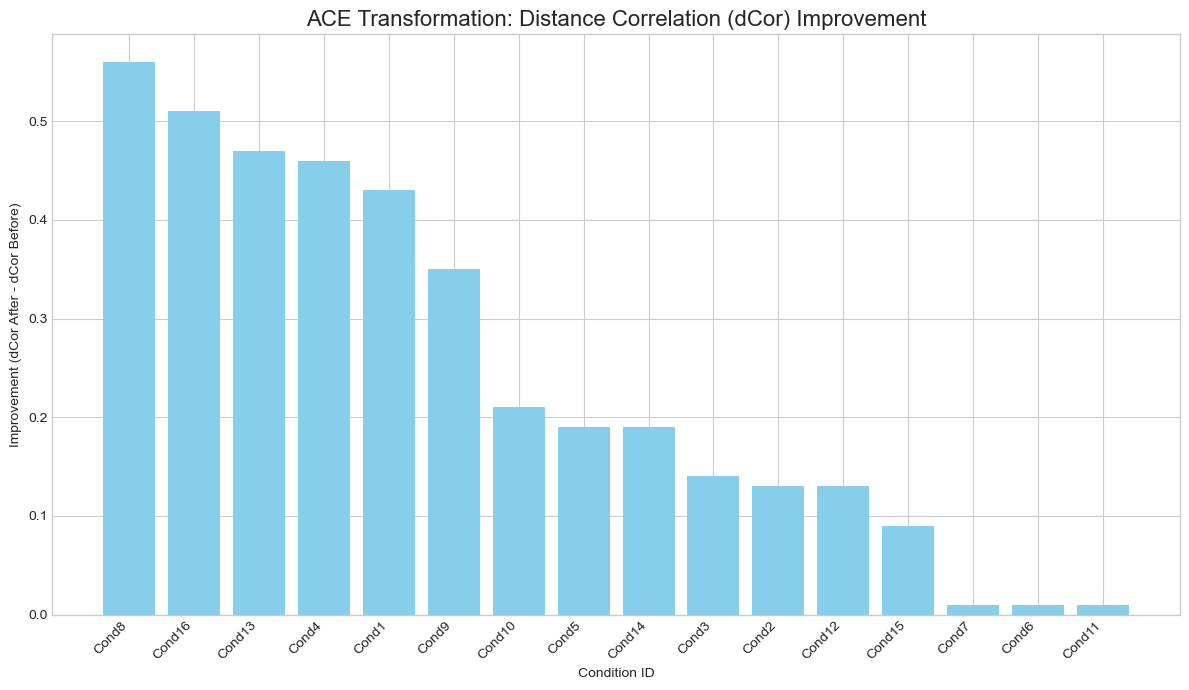

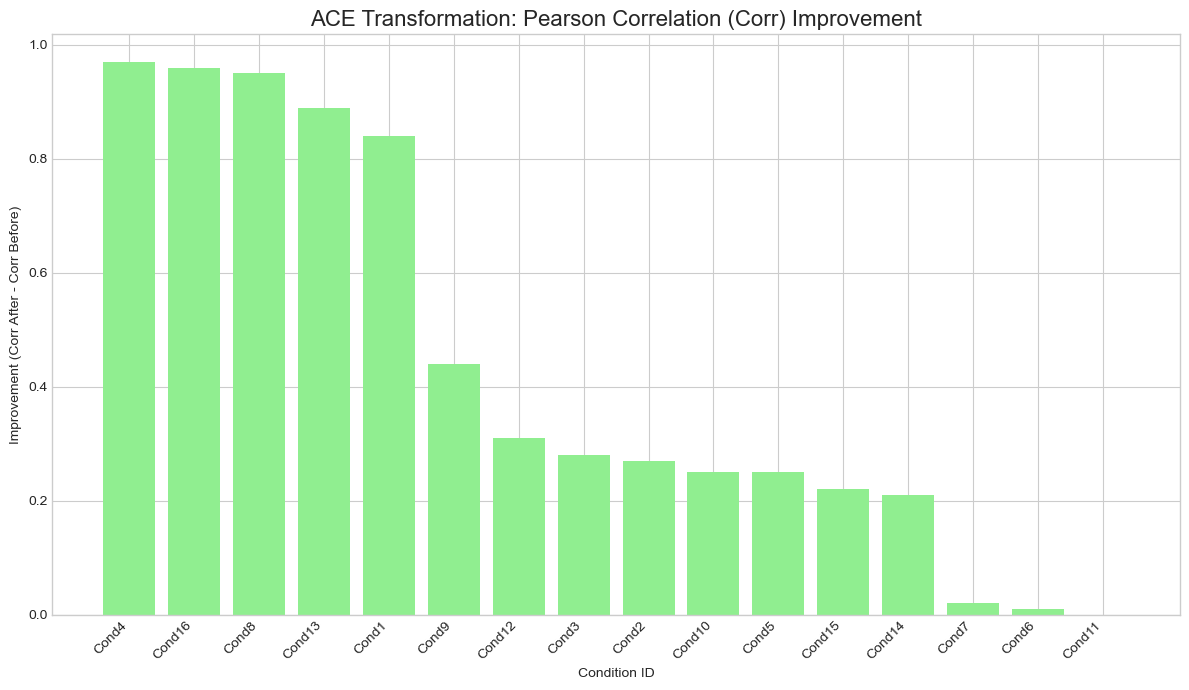

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터를 파이썬 리스트로 직접 정의 (파싱 오류 해결)
data = [
    ['Cond1', 'y = x^2', 'normal(0, 1)', 'normal(0, 1)', 0.06, 0.39, 0.90, 0.82],
    ['Cond2', 'y = x^2', 'uniform(-1, 1)', 'normal(0, 1)', 0.02, 0.14, 0.29, 0.27],
    ['Cond3', 'y = -x^2', 'uniform(-1, 1)', 'normal(0, 1)', 0.02, 0.14, 0.30, 0.28],
    ['Cond4', 'y = -x^2', 'normal(0, 1)', 'uniform(0, 1)', 0.02, 0.52, 0.99, 0.98],
    ['Cond5', 'y = x^3', 'normal(0, 1)', 'normal(0, 1)', 0.71, 0.74, 0.96, 0.93],
    ['Cond6', 'y = x^3', 'uniform(-1, 1)', 'normal(0, 1)', 0.32, 0.28, 0.33, 0.29],
    ['Cond7', 'y = -x^3', 'uniform(-1, 1)', 'normal(0, 1)', 0.34, 0.30, 0.36, 0.31],
    ['Cond8', 'y = x^4', 'normal(0, 1)', 'normal(0, 1)', 0.04, 0.43, 0.99, 0.99],
    ['Cond9', 'y = x^5', 'normal(0, 1)', 'normal(0, 1)', 0.53, 0.64, 0.97, 0.99],
    ['Cond10', 'y = e^x', 'normal(0, 1)', 'normal(0, 1)', 0.71, 0.71, 0.96, 0.92],
    ['Cond11', 'y = e^x', 'uniform(0, 1)', 'normal(0, 1)', 0.44, 0.40, 0.44, 0.41],
    ['Cond12', 'y = ln(|x|+1)', 'normal(0, 1)', 'normal(0, 1)', 0.01, 0.17, 0.32, 0.30],
    ['Cond13', 'y = x^2', 'normal(0, 1)', 'uniform(-1, 1)', 0.07, 0.46, 0.96, 0.93],
    ['Cond14', 'y = x^3', 'normal(0, 1)', 'uniform(-1, 1)', 0.78, 0.79, 0.99, 0.98],
    ['Cond15', 'y = e^x', 'normal(0, 1)', 'uniform(0, 1)', 0.76, 0.89, 0.98, 0.98],
    ['Cond16', 'y = x^2 + U(0, 0.1)', 'uniform(-1, 1)', 'uniform(0, 0.1)', 0.04, 0.48, 1.00, 0.99]
]

columns = ['ID', 'Function', 'X Dist.', 'Err Dist.', 'Corr Before', 'dCor Before', 'Corr After', 'dCor After']

df = pd.DataFrame(data, columns=columns)

# 2. 개선도 계산
df['Corr Improvement'] = df['Corr After'] - df['Corr Before']
df['dCor Improvement'] = df['dCor After'] - df['dCor Before']

# 3. 개선도 순위 계산
df['Corr Rank'] = df['Corr Improvement'].rank(method='min', ascending=False).astype(int)
df['dCor Rank'] = df['dCor Improvement'].rank(method='min', ascending=False).astype(int)

# 4. dCor 개선도 기준으로 정렬하여 표 출력
results_table = df.sort_values('dCor Rank')

print("ACE Transformation Improvement Results (sorted by dCor Rank)")
display(results_table[['ID', 'Function', 'dCor Before', 'dCor After', 'dCor Improvement', 'dCor Rank']])


# --- 5. 그래프 생성 ---

# dCor 개선도 그래프
df_sorted_dcor = df.sort_values('dCor Improvement', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.bar(df_sorted_dcor['ID'], df_sorted_dcor['dCor Improvement'], color='skyblue')
ax1.set_title('ACE Transformation: Distance Correlation (dCor) Improvement', fontsize=16)
ax1.set_ylabel('Improvement (dCor After - dCor Before)')
ax1.set_xlabel('Condition ID')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('dcor_improvement_rank.png')
plt.show()


# Corr 개선도 그래프
df_sorted_corr = df.sort_values('Corr Improvement', ascending=False)
fig2, ax2 = plt.subplots(figsize=(12, 7))
ax2.bar(df_sorted_corr['ID'], df_sorted_corr['Corr Improvement'], color='lightgreen')
ax2.set_title('ACE Transformation: Pearson Correlation (Corr) Improvement', fontsize=16)
ax2.set_ylabel('Improvement (Corr After - Corr Before)')
ax2.set_xlabel('Condition ID')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('corr_improvement_rank.png')
plt.show()